In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
df = pd.read_parquet(filename)
df.head(5)

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,image_name,image_index,is_change,omitted,...,ophys_session_id,ophys_container_id,behavior_session_id,full_genotype,reporter_line,driver_line,indicator,sex,age_in_days,exposure_level
85,5,1086496689,"[0.06366926431655884, 0.002476318972185254, -0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.006115,-0.084113,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
86,5,1086501573,"[0.0637083426117897, 0.0919334813952446, -0.09...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.018832,-0.025578,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
87,5,1086500533,"[0.0223990511149168, 0.22551870346069336, 0.11...","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.041275,-0.032698,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
88,5,1086497438,"[0.01795899122953415, 0.15271763503551483, 0.0...","[-1.228133913303992, -1.1958145997959921, -1.1...",0.039527,-0.026750,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar
89,5,1086497908,"[0.059766266494989395, 0.03602207452058792, 0....","[-1.228133913303992, -1.1958145997959921, -1.1...",-0.006628,-0.039277,im075,2,True,False,...,994199725,991913453,994210659,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],GCaMP6f,M,196.0,familiar


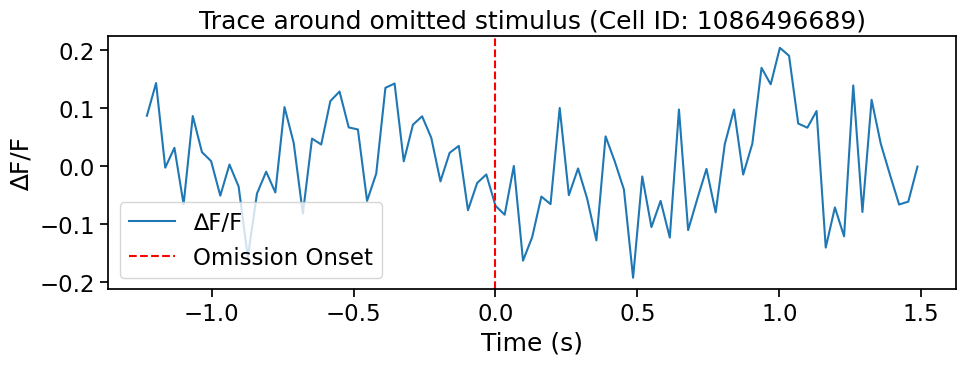

In [4]:
# Select one omitted event for SST or VIP neuron
example = df[(df['omitted']) & (df['cre_line'].str.contains("Sst"))].iloc[0]

trace = example['trace']
timestamps = example['trace_timestamps']

# Plot the trace
plt.figure(figsize=(10, 4))
plt.plot(timestamps, trace, label='∆F/F')
plt.axvline(0, color='red', linestyle='--', label='Omission Onset')
plt.xlabel('Time (s)')
plt.ylabel('∆F/F')
plt.title(f"Trace around omitted stimulus (Cell ID: {example['cell_specimen_id']})")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Parameters
pre_time = 1.0   # seconds before event
post_time = 2.0  # seconds after event
sampling_rate = 30  # approximate Hz

window_size = int((pre_time + post_time) * sampling_rate)
time_axis = np.linspace(-pre_time, post_time, window_size)

def extract_aligned_trace(trace, timestamps, pre=1.0, post=2.0, target_time=0.0, baseline_correct=True):
    trace = np.array(trace)
    timestamps = np.array(timestamps)
    window_mask = (timestamps >= target_time - pre) & (timestamps <= target_time + post)

    if np.sum(window_mask) == 0:
        return None

    aligned_t = timestamps[window_mask] - target_time
    aligned_trace = trace[window_mask]

    # Interpolate to fixed time axis
    interpolated = np.interp(time_axis, aligned_t, aligned_trace)

    # ✅ Baseline correction
    if baseline_correct:
        baseline = np.mean(interpolated[time_axis < 0])  # pre-stimulus window
        interpolated -= baseline

    return interpolated



In [6]:
conditions = []

for i, row in df.iterrows():
    if row['trace'] is None or row['trace_timestamps'] is None:
        continue

    aligned = extract_aligned_trace(row['trace'], row['trace_timestamps'], target_time=0.0)
    if aligned is None:
        continue

    conditions.append({
        'aligned_trace': aligned,
        'omitted': row['omitted'],
        'exposure_level': row['exposure_level'],
        'cre_line': row['cre_line'],
        'cell_specimen_id': row['cell_specimen_id'],
        'mouse_id': row['mouse_id'],
        'ophys_session_id': row['ophys_session_id']
    })

erp_df = pd.DataFrame(conditions)
display(erp_df)



,aligned_trace,omitted,exposure_level,cre_line,cell_specimen_id,mouse_id,ophys_session_id
0,"[-0.053580434696160875, -0.0487327413767199, 0...",False,familiar,Sst-IRES-Cre,1086496689,476970,994199725
1,"[0.01825134147668202, 0.01928642389664918, 0.0...",False,familiar,Sst-IRES-Cre,1086501573,476970,994199725
2,"[-0.1773781647971691, -0.14745078167799264, 0....",False,familiar,Sst-IRES-Cre,1086500533,476970,994199725
3,"[-0.11358428462385016, -0.09772559698684671, 0...",False,familiar,Sst-IRES-Cre,1086497438,476970,994199725
4,"[0.058551863841471666, 0.055940363809258195, 0...",False,familiar,Sst-IRES-Cre,1086497908,476970,994199725
...,...,...,...,...,...,...,...
147690,"[0.018855836086008097, 0.010858547205151602, -...",True,novel,Vip-IRES-Cre,1086498401,467954,963496285
147691,"[0.045185826520330034, 0.043971184778006545, 0...",True,novel,Vip-IRES-Cre,1086498544,467954,963496285
147692,"[-0.03191127673710915, -0.025538074772072903, ...",True,novel,Vip-IRES-Cre,1086498699,467954,963496285
147693,"[0.18686019814196436, 0.1970756223398774, 0.26...",True,novel,Vip-IRES-Cre,1086498889,467954,963496285


In [8]:
erp_df.isna().sum().sum()

0

In [9]:
# Ensure 'erp_df' has aligned traces and metadata
assert 'aligned_trace' in erp_df.columns

# Drop any incomplete entries
erp_mvpa = erp_df.dropna(subset=['aligned_trace', 'cre_line', 'exposure_level', 'omitted'])

# Build decoding labels for multivariate analysis
# e.g., combine all conditions into a unique label: "VIP_Familiar_Omitted", etc.
erp_mvpa['ConditionLabel'] = (
    erp_mvpa['cre_line'].str.replace('-IRES-Cre', '', regex=False) + '_' +
    erp_mvpa['exposure_level'].str.capitalize() + '_' +
    erp_mvpa['omitted'].map({True: 'Omitted', False: 'Presented'})
)

# Sanity check — view label counts
print(erp_mvpa['ConditionLabel'].value_counts())

# Stack ERP matrix for X and extract class labels for y
X = np.stack(erp_mvpa['aligned_trace'].values)  # shape (n_trials, n_timepoints)
y = erp_mvpa['ConditionLabel'].values           # shape (n_trials,)

print("X shape:", X.shape)
print("y sample:", np.unique(y))


Vip_Familiar_Presented    28121
Sst_Familiar_Presented    25380
Vip_Novel_Presented       23491
Vip_Familiar_Omitted      21639
Sst_Familiar_Omitted      18212
Vip_Novel_Omitted         14963
Sst_Novel_Presented        8970
Sst_Novel_Omitted          6919
Name: ConditionLabel, dtype: int64
X shape: (147695, 90)
y sample: ['Sst_Familiar_Omitted' 'Sst_Familiar_Presented' 'Sst_Novel_Omitted'
 'Sst_Novel_Presented' 'Vip_Familiar_Omitted' 'Vip_Familiar_Presented'
 'Vip_Novel_Omitted' 'Vip_Novel_Presented']


## **Filter ERP Data:  Vip_familiar , Vip_novel , Sst_familiar , Sst_novel**


In [22]:
import numpy as np

# Container for all data splits
mvpa_data = {}

# Define groups
groups = [
    ('Vip', 'familiar'),
    ('Vip', 'novel'),
    ('Sst', 'familiar'),
    ('Sst', 'novel')
]

# Loop over all cell type × exposure combinations
for cre, exposure in groups:
    mask = (
        erp_mvpa['cre_line'].str.contains(cre) &
        (erp_mvpa['exposure_level'] == exposure)
    )

    df_subset = erp_mvpa[mask].copy()
    df_subset['Label'] = df_subset['omitted'].astype(int)

    # Create ERP matrix and labels
    X = np.stack(df_subset['aligned_trace'].values)
    y = df_subset['Label'].values

    # Store
    key = f"{cre}_{exposure}"
    mvpa_data[key] = {
        "df": df_subset,
        "X": X,
        "y": y
    }

    # Quick report
    print(f"{key}: X shape = {X.shape} | Omitted = {np.sum(y)} | Presented = {len(y) - np.sum(y)}")


Vip_familiar: X shape = (49760, 90) | Omitted = 21639 | Presented = 28121
Vip_novel: X shape = (38454, 90) | Omitted = 14963 | Presented = 23491
Sst_familiar: X shape = (43592, 90) | Omitted = 18212 | Presented = 25380
Sst_novel: X shape = (15889, 90) | Omitted = 6919 | Presented = 8970


#### **Create 4 subsets from the dataset**

In [29]:
X_Vip_familiar = mvpa_data['Vip_familiar']['X']
y_Vip_familiar = mvpa_data['Vip_familiar']['y']

X_Vip_novel = mvpa_data['Vip_novel']['X']
y_Vip_novel = mvpa_data['Vip_novel']['y']

X_Sst_familiar = mvpa_data['Sst_familiar']['X']
y_Sst_familiar = mvpa_data['Sst_familiar']['y']

X_Sst_novel = mvpa_data['Sst_novel']['X']
y_Sst_novel = mvpa_data['Sst_novel']['y']


## **Defining  Time Resolved Decoding function**

**What This Does**

Trains a classifier at every time point across ERP traces

Outputs AUC over time to see when VIP neurons distinguish omitted vs presented

Reveals temporal dynamics of predictive coding

In [32]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from itertools import groupby

def time_resolved_decoding(X, y, n_splits=10):
    n_timepoints = X.shape[1]
    auc_scores = np.zeros(n_timepoints)
    acc_scores = np.zeros(n_timepoints)

    for t in range(n_timepoints):
        X_t = X[:, t].reshape(-1, 1)

        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        aucs, accs = [], []

        for train_idx, test_idx in cv.split(X_t, y):
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_t[train_idx])
            X_test = scaler.transform(X_t[test_idx])

            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y[train_idx])

            probas = clf.predict_proba(X_test)[:, 1]
            preds = clf.predict(X_test)

            aucs.append(roc_auc_score(y[test_idx], probas))
            accs.append(accuracy_score(y[test_idx], preds))

        auc_scores[t] = np.mean(aucs)
        acc_scores[t] = np.mean(accs)

    return auc_scores, acc_scores

def group_contiguous(arr):
    arr = sorted(arr)
    return [list(group) for _, group in groupby(arr, key=lambda x, c=iter(arr): x - next(c, x))]

def format_intervals(index_list, label, time_axis):
    clusters = group_contiguous(index_list)
    if not clusters:
        return f"No {label} time windows above threshold."
    lines = [f"  ➤ {label} window: {time_axis[g[0]]:.3f}s to {time_axis[g[-1]]:.3f}s" for g in clusters if len(g) >= 2]
    return "\n".join(lines)

def summarize_results(auc_scores, acc_scores, time_axis, label=""):
    pre_mask = time_axis < 0
    post_mask = time_axis >= 0

    summary = f"🔍 === Time-Resolved Decoding Summary: {label} === 🔍\n\n"

    summary += f"🔹 AUC Stats\n"
    summary += f"  • Max AUC:           {np.max(auc_scores):.3f} at {time_axis[np.argmax(auc_scores)]:.3f} s\n"
    summary += f"  • Mean AUC (pre):    {np.mean(auc_scores[pre_mask]):.3f}\n"
    summary += f"  • Mean AUC (post):   {np.mean(auc_scores[post_mask]):.3f}\n"

    threshold_auc = 0.6
    above_auc = np.where(auc_scores > threshold_auc)[0]
    summary += f"  • Timepoints AUC > {threshold_auc}: {len(above_auc)}\n\n"

    summary += f"🔹 Accuracy Stats\n"
    summary += f"  • Max Accuracy:      {np.max(acc_scores):.3f} at {time_axis[np.argmax(acc_scores)]:.3f} s\n"
    summary += f"  • Mean Accuracy (pre):  {np.mean(acc_scores[pre_mask]):.3f}\n"
    summary += f"  • Mean Accuracy (post): {np.mean(acc_scores[post_mask]):.3f}\n"

    threshold_acc = 0.65
    above_acc = np.where(acc_scores > threshold_acc)[0]
    summary += f"  • Timepoints Accuracy > {threshold_acc}: {len(above_acc)}\n\n"

    summary += f"📊 High-Performance Time Windows:\n"
    summary += format_intervals(above_auc, "AUC", time_axis) + "\n"
    summary += format_intervals(above_acc, "Accuracy", time_axis) + "\n"

    return summary

def plot_auc_accuracy(time_axis, auc_scores, acc_scores, title="Decoding"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(time_axis, auc_scores, label='AUC', color='royalblue')
    plt.axvline(0, color='red', linestyle='--', label='Stimulus/Omission')
    plt.xlabel('Time (s)')
    plt.ylabel('AUC')
    plt.ylim(0.4, 1.0)
    plt.title(f'{title} - AUC')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(time_axis, acc_scores, label='Accuracy', color='green')
    plt.axvline(0, color='red', linestyle='--', label='Stimulus/Omission')
    plt.xlabel('Time (s)')
    plt.ylabel('Accuracy')
    plt.ylim(0.4, 1.0)
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## **Performing TRD on 4 subsets and report the results and accuracy, AUC plots**

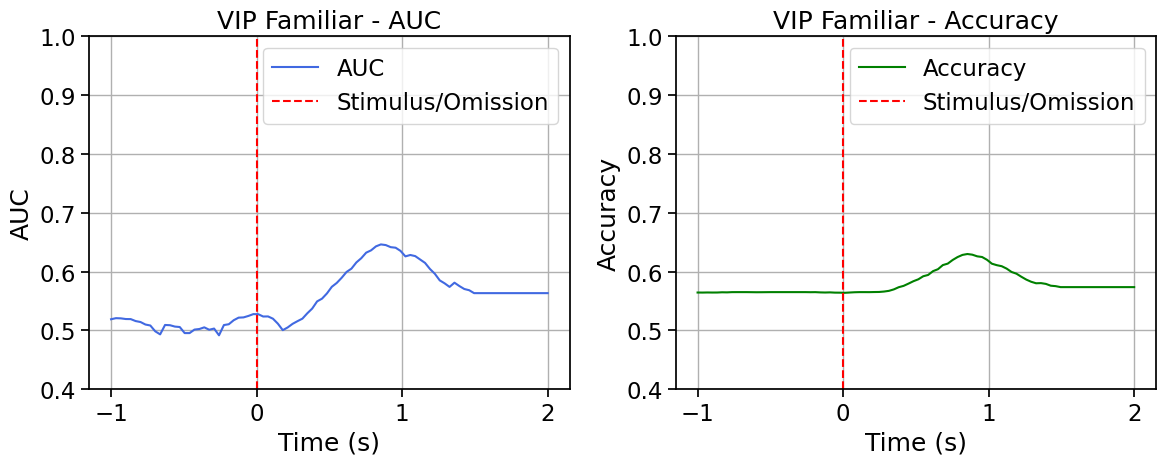

🔍 === Time-Resolved Decoding Summary: VIP Familiar === 🔍

🔹 AUC Stats
  • Max AUC:           0.646 at 0.854 s
  • Mean AUC (pre):    0.510
  • Mean AUC (post):   0.576
  • Timepoints AUC > 0.6: 17

🔹 Accuracy Stats
  • Max Accuracy:      0.630 at 0.854 s
  • Mean Accuracy (pre):  0.565
  • Mean Accuracy (post): 0.587
  • Timepoints Accuracy > 0.65: 0

📊 High-Performance Time Windows:
  ➤ AUC window: 0.652s to 1.191s
No Accuracy time windows above threshold.



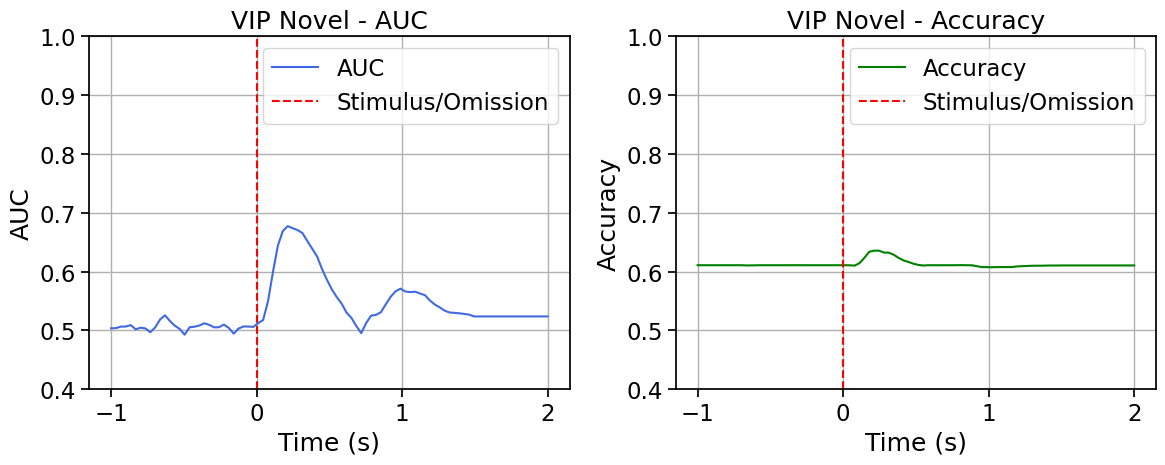

🔍 === Time-Resolved Decoding Summary: VIP Novel === 🔍

🔹 AUC Stats
  • Max AUC:           0.677 at 0.213 s
  • Mean AUC (pre):    0.506
  • Mean AUC (post):   0.556
  • Timepoints AUC > 0.6: 10

🔹 Accuracy Stats
  • Max Accuracy:      0.636 at 0.213 s
  • Mean Accuracy (pre):  0.611
  • Mean Accuracy (post): 0.613
  • Timepoints Accuracy > 0.65: 0

📊 High-Performance Time Windows:
  ➤ AUC window: 0.146s to 0.449s
No Accuracy time windows above threshold.



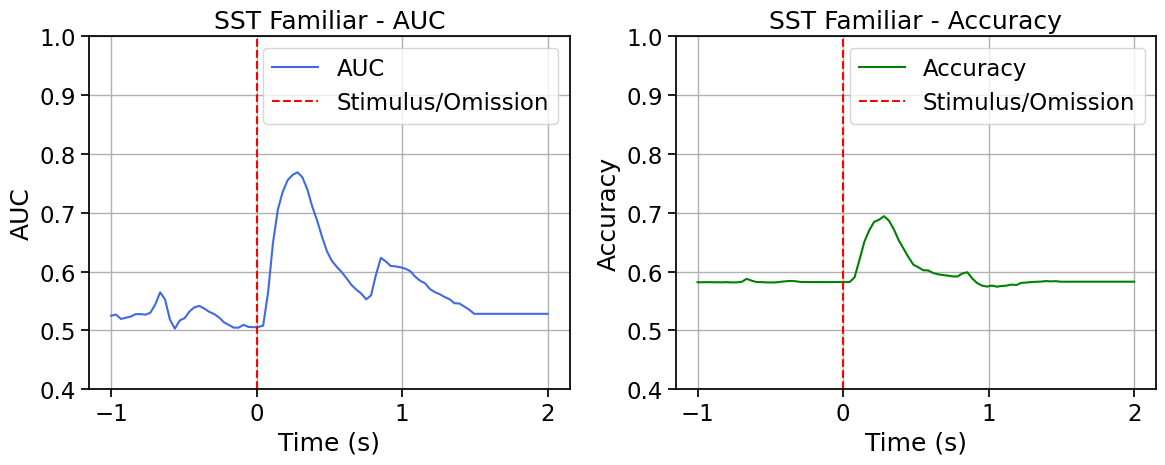

🔍 === Time-Resolved Decoding Summary: SST Familiar === 🔍

🔹 AUC Stats
  • Max AUC:           0.769 at 0.281 s
  • Mean AUC (pre):    0.525
  • Mean AUC (post):   0.591
  • Timepoints AUC > 0.6: 21

🔹 Accuracy Stats
  • Max Accuracy:      0.694 at 0.281 s
  • Mean Accuracy (pre):  0.583
  • Mean Accuracy (post): 0.600
  • Timepoints Accuracy > 0.65: 8

📊 High-Performance Time Windows:
  ➤ AUC window: 0.112s to 1.056s
  ➤ Accuracy window: 0.146s to 0.382s



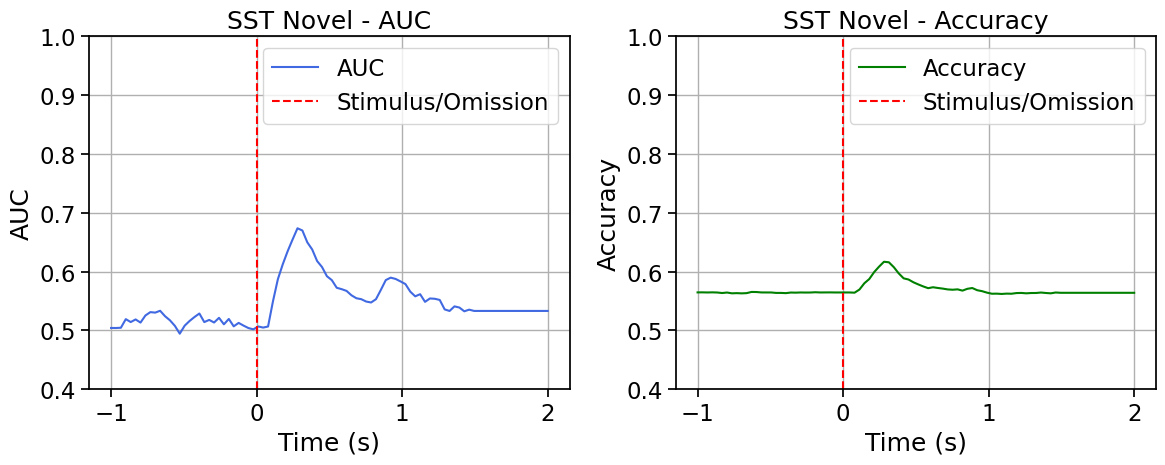

🔍 === Time-Resolved Decoding Summary: SST Novel === 🔍

🔹 AUC Stats
  • Max AUC:           0.674 at 0.281 s
  • Mean AUC (pre):    0.515
  • Mean AUC (post):   0.563
  • Timepoints AUC > 0.6: 9

🔹 Accuracy Stats
  • Max Accuracy:      0.617 at 0.281 s
  • Mean Accuracy (pre):  0.564
  • Mean Accuracy (post): 0.572
  • Timepoints Accuracy > 0.65: 0

📊 High-Performance Time Windows:
  ➤ AUC window: 0.180s to 0.449s
No Accuracy time windows above threshold.



In [ ]:
# Load your data
X_Vip_familiar = mvpa_data['Vip_familiar']['X']
y_Vip_familiar = mvpa_data['Vip_familiar']['y']

X_Vip_novel = mvpa_data['Vip_novel']['X']
y_Vip_novel = mvpa_data['Vip_novel']['y']

X_Sst_familiar = mvpa_data['Sst_familiar']['X']
y_Sst_familiar = mvpa_data['Sst_familiar']['y']

X_Sst_novel = mvpa_data['Sst_novel']['X']
y_Sst_novel = mvpa_data['Sst_novel']['y']

time_axis = np.linspace(-1, 2, X_Vip_familiar.shape[1])  # same for all

conditions = {
    "VIP Familiar": (X_Vip_familiar, y_Vip_familiar),
    "VIP Novel": (X_Vip_novel, y_Vip_novel),
    "SST Familiar": (X_Sst_familiar, y_Sst_familiar),
    "SST Novel": (X_Sst_novel, y_Sst_novel)
}

reports = {}

for name, (X, y) in conditions.items():
    auc_scores, acc_scores = time_resolved_decoding(X, y)
    plot_auc_accuracy(time_axis, auc_scores, acc_scores, title=name)
    report = summarize_results(auc_scores, acc_scores, time_axis, label=name)
    print(report)
    reports[name] = report  # optional for later use


## **time-resolved decoding with permutation testing for statistical significance**

In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def time_resolved_decoding_with_permutation(X, y, time_axis, n_splits=10, n_permutations=1000, random_state=42):
    np.random.seed(random_state)
    n_timepoints = X.shape[1]
    true_auc_scores = np.zeros(n_timepoints)
    permutation_auc_scores = np.zeros((n_permutations, n_timepoints))

    # Compute true AUC
    for t in range(n_timepoints):
        X_t = X[:, t].reshape(-1, 1)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        aucs = []

        for train_idx, test_idx in cv.split(X_t, y):
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_t[train_idx])
            X_test = scaler.transform(X_t[test_idx])
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X_train, y[train_idx])
            probas = clf.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y[test_idx], probas))

        true_auc_scores[t] = np.mean(aucs)

    # Permutation testing
    for perm in tqdm(range(n_permutations), desc="Permutation Testing"):
        y_permuted = np.random.permutation(y)
        for t in range(n_timepoints):
            X_t = X[:, t].reshape(-1, 1)
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
            aucs = []

            for train_idx, test_idx in cv.split(X_t, y_permuted):
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_t[train_idx])
                X_test = scaler.transform(X_t[test_idx])
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X_train, y_permuted[train_idx])
                probas = clf.predict_proba(X_test)[:, 1]
                aucs.append(roc_auc_score(y_permuted[test_idx], probas))

            permutation_auc_scores[perm, t] = np.mean(aucs)

    # Compute p-values
    p_values = np.mean(permutation_auc_scores >= true_auc_scores[None, :], axis=0)

    return true_auc_scores, p_values, permutation_auc_scores


In [ ]:
true_auc, pvals, perms = time_resolved_decoding_with_permutation(X_Vip_familiar, y_Vip_familiar, time_axis)

## **Visualize AUC with Significant Time Points**

In [ ]:
import matplotlib.pyplot as plt

def plot_auc_with_significance(time_axis, auc_scores, p_values, alpha=0.05, title="Time-Resolved Decoding AUC"):
    plt.figure(figsize=(10, 5))

    # Plot AUC
    plt.plot(time_axis, auc_scores, label="AUC", color="royalblue")
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='red', linestyle='--', label="Stimulus/Omission")

    # Highlight significant time points
    sig_mask = p_values < alpha
    plt.fill_between(time_axis, 0.5, 1.0, where=sig_mask, color="orange", alpha=0.2, label=f"p < {alpha}")

    # Labels and formatting
    plt.xlabel("Time (s)")
    plt.ylabel("AUC")
    plt.ylim(0.4, 1.0)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Assuming you already have:
# - auc_scores from real labels
# - p_values from permutation test
# - time_axis

plot_auc_with_significance(
    time_axis=time_axis,
    auc_scores=true_auc,
    p_values=pvals,
    alpha=0.05,
    title="VIP Familiar: AUC with Significant Time Points"
)


**Permutation testing** is a **non-parametric statistical method** used to assess whether an observed effect (like classification accuracy or AUC) is **statistically 

significant** — i.e., unlikely to have occurred by chance.

---

### 🧠 **In Simple Terms:**

It **asks this question**:

> *“If there were no real relationship between the labels and the data, what kind of decoding performance would I expect just by random chance?”*

Then it compares your **real decoding performance** to that **null distribution** to calculate a **p-value**.

---

### 🔧 **How it Works (Step-by-Step):**

1. **Compute real performance (e.g., AUC)**

   * Using the true labels and your classifier.

2. **Randomly shuffle the labels**

   * This destroys the true relationship between your features and labels.

3. **Repeat many times (e.g., 1000 permutations)**:

   * For each shuffle, compute performance (AUC, accuracy).

   * Build a distribution of AUCs under the null hypothesis (no relationship).

4. **Compare real AUC to the permutation distribution**

   * Count how many permutations produced an AUC **equal to or greater than** your real AUC.

   * This proportion is the **p-value**.

---

### 📊 **What It Tells Us:**

* A **low p-value** (e.g., p < 0.05) means your model's performance is **significantly better** than expected by chance.

* A **high p-value** means the observed decoding could have easily occurred by chance — no significant effect.

---

### ✅ **Why it's great for neuroscience / ERP MVPA:**

* Doesn't assume normal distribution of scores.

* Works well with small or irregular data.

* Accounts for the specific structure of your data.

---

### 🔁 Example:

> Real AUC = 0.72
> Permutation AUCs (1000 shuffles): mean = 0.50, std = 0.03

> Only 8 of 1000 permutations had AUC ≥ 0.72 → p = 0.008

> **Interpretation**: The model’s performance is **highly unlikely by chance**.

---


